In [1]:
%pylab inline

import scipy.interpolate
import astropy.table
import astropy.units as u
import csv
import pandas as pd
import tmm

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_refraction_data(kind='linear'):
    
    interpolators = {}
    
    # Vacuum.
    interpolators['Vacuum'] = lambda wlen: np.ones_like(wlen)
    
    # Use optical properties of crystaline silicon tabulated at:
    # https://www2.pvlighthouse.com.au/Resources/Photovoltaic%20materials/Refractive%20index/Refractive%20index.aspx
    # Absorption data at 295K is originally from:
    # C. Schinke, P.C Peest, J. Schmidt, R. Brendel, K. Bothe, M.R Vogt, I. Kröger,
    # S. Winter, A. Schirmacher, S. Lim, et al.,'Uncertainty analysis for the coefficient
    # of band-to-band absorption of crystalline silicon', AIP Advances 5, p. 067168, 2015.
    # Index of refraction is calculated using:
    # M. Green, 'Self-consistent optical parameters of intrinsic silicon at 300K including
    # temperature coefficients', Solar Energy Materials & Solar Cells 92, pp. 1305–1310, 2008.
    abs_table = astropy.table.Table.read('data/Si-absorption.csv', format='ascii.csv', names=('wlen', 'k', 'a'))
    table = astropy.table.Table.read('data/Si-index.csv', format='ascii.csv', names=('wlen', 'n'))
    wlen = abs_table['wlen']
    k = abs_table['k']
    
    # Interpolate n onto the finer grid used for k.
    n = np.interp(wlen, table['wlen'], table['n'])
    
    # Build a linear interpolator of the complex index of refraction vs wavelength [nm].
    n = n + 1.j * k
    interpolators['Si'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)

    # Si index for T = 173K
    abs_table3 = astropy.table.Table.read('data/Si_index_Green.csv',format = 'ascii.csv')
    wlen3 = abs_table3['wlen']*1e3
    k3 = abs_table3['k']
    c_n = abs_table3['C_n']
    c_k = abs_table3['C_k']
    def Temp_Si_index (index, tem_coeff, T = 173):
        
        T0 = 300.0
        b = tem_coeff * 1e-4 * T0
        index_temp = index * (T / T0)**b
    
        return(index_temp)
    n_173 = Temp_Si_index(abs_table3['n'],c_n,T = 173.)
    k_173 = Temp_Si_index(abs_table3['k'],c_k,T = 173.)
    # Interpolate n onto the finer grid used for k.
    n_173 = np.interp(wlen3, abs_table3['wlen']*1e3, n_173)

    # Build a linear interpolator of the complex index of refraction vs wavelength [nm].
    n_173 = n_173 + 1.j * k_173
    interpolators['Si_Green_173'] = scipy.interpolate.interp1d(wlen3, n_173, copy=True, kind= kind)
    
    # Read tabulated Si3N4 data from
    # http://refractiveindex.info/?shelf=main&book=Si3N4&page=Philipp
    table = astropy.table.Table.read('data/Si3N4-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['Si3N4'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)

    # Read SiO2 tabulated data from
    # http://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    table = astropy.table.Table.read('data/SiO2-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['SiO2'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)

    # Read MgF2 tabulated data from
    # http://refractiveindex.info/?shelf=main&book=MgF2&page=Li-o
    table = astropy.table.Table.read('data/MgF2-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['MgF2'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)
    
    return interpolators

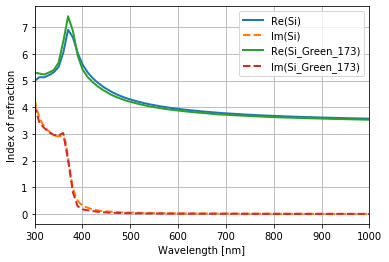

In [3]:
index_of_refraction = load_refraction_data()
def plot_refraction(wlen_min=300., wlen_max=1000.):
    plt.figure(figsize = (6,4))
    wlen = np.linspace(wlen_min, wlen_max, 2000)
    for name, n_func in index_of_refraction.items():
        n = n_func(wlen)
        im_n = np.imag(n)
        if np.any(im_n != 0):
            plt.plot(wlen, np.real(n), lw=2, label='Re({0})'.format(name))
            plt.plot(wlen, im_n, lw=2, ls='--', label='Im({0})'.format(name))
        #else:
            #plt.plot(wlen, n, lw=2, label=name)
    plt.legend()
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Index of refraction')
    plt.xlim(wlen_min, wlen_max)
    plt.grid()

plot_refraction()

In [4]:
def dthick (nwaves = 0.5,nsteps = 50,wlen = 950.*u.nm, geo = 'linear'):
    # Customize the tilting type for each layer
    if geo == 'flat':
        dthick_waves = np.zeros(nsteps)
        
    elif geo == 'linear':
        dthick_waves = np.linspace(-nwaves, +nwaves, nsteps)

    elif geo == 'vshape':
        dthick_waves = np.linspace(+nwaves, 0, nsteps/2.)
        dthick_waves = np.append(dthick_waves,np.linspace(0, +nwaves, nsteps/2.))  

    dthick_um = wlen.to(u.um).value * dthick_waves

    return(dthick_um)

In [5]:
thickness_um = [np.inf,  100., 0.15, np.inf]
material = ('Vacuum', 'Si_Green_173', 'SiO2','Vacuum')
layer_tilt = ['','x','y','']

def muti_layer(Material = material,wlen = 950.*u.nm,Beam_type = 'LSST_beam',thickness_um = thickness_um,layer_tilt = layer_tilt):
    
    wlen = wlen 
    material = Material 
    thickness_um = thickness_um
    n_list = [index_of_refraction[m](wlen.to(u.nm).value) for m in material]  
    dthick_um = dthick(wlen = wlen,geo = 'linear')  
    absor_sum = np.zeros((len(dthick_um), len(dthick_um)))
    
    # Choose the beam for simulation
    if Beam_type == 'LSST_beam':
        th_min=14.3*u.deg
        th_max=22.1*u.deg
        
        # Initialize integration over incidence angles in the LSST beam.
        th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 25)
        wgt = th_rad / np.sum(th_rad)
        
    elif Beam_type == 'Normal':
        # Normal incidence
        th_rad = np.array([0.])
        wgt = np.array([1.])
    
    x_tilt_index = []
    y_tilt_index = []
    for i,tilt in enumerate(layer_tilt):

        if 'x' in tilt:
            x_tilt_index.append(i)
        if 'y' in tilt:
            y_tilt_index.append(i)
            
    print('X direction tilted layer: ', x_tilt_index)
    print('Y direction tilt layer: ',y_tilt_index)
    
    for j,y_dthick in enumerate(dthick_um):
        for k, x_dthick in enumerate(dthick_um):
            
            new_thickness_um = thickness_um[:]
            
            for jj,y_index in enumerate(y_tilt_index):
                new_thickness_um[y_index] = new_thickness_um[y_index] + y_dthick
                new_thickness_um[y_index+1] = new_thickness_um[y_index + 1] - y_dthick
            
            for kk,x_index in enumerate(x_tilt_index):
                new_thickness_um[x_index] = new_thickness_um[x_index] + x_dthick
                new_thickness_um[x_index+1] = new_thickness_um[x_index + 1] - x_dthick
                for theta, weight in zip(th_rad, wgt):
                    for pol in 'sp':
                        results = tmm.coh_tmm(pol, n_list, new_thickness_um, theta, wlen.to(u.um).value)
                        absor_sum[j, k] += 0.5 * weight * (1. - results['T'] - results['R'])

    return(absor_sum)

In [6]:
thickness_um = [np.inf,  100., 0.15, np.inf]
material = ('Vacuum', 'Si_Green_173', 'SiO2','Vacuum')
layer_tilt = ['','x','y','']

absorb2d_173 = {}

absorb2d_173[(1,1)] = muti_layer(Material = material,wlen = 850.*u.nm,Beam_type = 'Normal',
                                thickness_um = thickness_um,layer_tilt = layer_tilt)

absorb2d_173[(1,2)] = muti_layer(Material = material,wlen = 850.*u.nm,Beam_type = 'LSST_beam',
                                thickness_um = thickness_um,layer_tilt = layer_tilt)

X direction tilted layer:  [1]
Y direction tilt layer:  [2]
X direction tilted layer:  [1]
Y direction tilt layer:  [2]


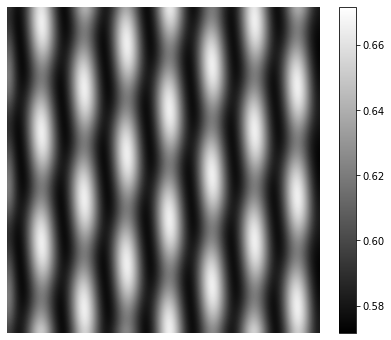

In [7]:
# Normal Incidence
plt.figure(figsize = (7,6))
extends = 1.
plt.imshow(absorb2d_173[(1, 1)],interpolation='bicubic', aspect='auto', cmap='gray', 
           origin='lower',extent=(-extends, extends, -extends, extends))
plt.axis('off');
plt.colorbar();

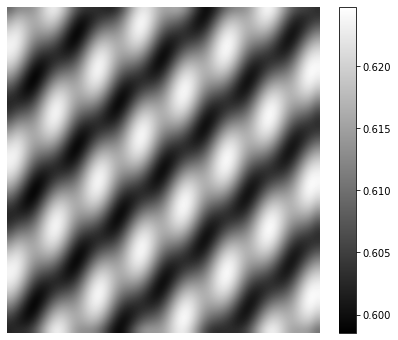

In [8]:
# LSST Beam
plt.figure(figsize = (7,6))
extends = 1.
plt.imshow(absorb2d_173[(1, 2)],interpolation='bicubic', aspect='auto', cmap='gray', 
           origin='lower',extent=(-extends, extends, -extends, extends))
plt.axis('off');
plt.colorbar();